In [22]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/', one_hot = False)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [23]:
x_treinamento = mnist.train.images
y_treinamento = mnist.train.labels
x_teste = mnist.test.images
y_teste = mnist.test.labels

In [24]:
y_treinamento = np.asarray(y_treinamento, dtype = np.int32)
y_teste = np.asarray(y_teste, dtype = np.int32)

In [25]:
x_treinamento.shape

(55000, 784)

In [26]:
x_teste.shape

(10000, 784)

In [27]:
y_treinamento

array([7, 3, 4, ..., 5, 6, 8])

Text(0.5, 1.0, 'Classe: 7')

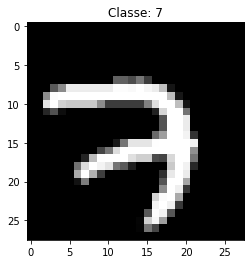

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_treinamento[0].reshape((28,28)), cmap = 'gray')
plt.title('Classe: ' + str(y_treinamento[0]))

In [29]:
import tensorflow as tf

In [30]:
def cria_rede(features, labels, mode):
    #batch_size, largura, altura, canais -------v
    entrada = tf.reshape(features['X'], [-1, 28, 28, 1])
    
    #recebe [batch_size, 28,28, 1]
    #tretorna [batch_size, 28, 28, 32]
    convolucao1 = tf.layers.conv2d(inputs = entrada, filters = 32, kernel_size = [5, 5], activation = tf.nn.relu, 
                                   padding = 'same')
    
    #recebe [batch_size, 28, 28, 32]
    #retorna [batch_size, 14, 14, 32]
    pooling1 = tf.layers.max_pooling2d(inputs = convolucao1, pool_size = [2,2], strides = 2)
    
    #recebe [batch_size, 14, 14, 32]
    #retorna [batch_size, 14, 14, 64]
    convolucao2 = tf.layers.conv2d(inputs = pooling1, filters = 64, kernel_size = [5, 5], activation = tf.nn.relu,
                                  padding = 'same')
    
    #recebe [batch_size, 14, 14, 64]
    #retorna [batch_size, 7, 7, 64]
    pooling2 = tf.layers.max_pooling2d(inputs = convolucao2, pool_size = [2,2], strides = 2)
    
    #recebe [batch_size, 7, 7, 64]
    #retorna [batch_size, 3236] --- um 'vetor'
    flattening = tf.reshape(pooling2, [-1, 7 * 7 * 64])
    
    #entrada 3136 -> 1024[oculta] -> saida 10      [neuronios]
    #recebe 3136 neuronios
    #retorna [batch_size, 1024]
    densa = tf.layers.dense(inputs = flattening, units = 1024, activation = tf.nn.relu)
    
    #dropout
    dropout = tf.layers.dropout(inputs = densa, rate = 0.2, training = mode == tf.estimator.ModeKeys.TRAIN)
    
    #recebe [batch_size, 1024]
    #retorna [batch_size , 10]
    saida = tf.layers.dense(inputs = dropout, units = 10)
    
    # 0.2 0.2 0.6 = digito 2
    previsoes = tf.argmax(saida, axis = 1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = previsoes)
    
    erro = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = saida)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        otimizador = tf.train.AdamOptimizer(learning_rate = 0.001)
        treinamento = otimizador.minimize(erro, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = erro, train_op = treinamento)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics_ops = {'accuracy': tf.metrics.accuracy(labels = labels, predictions = previsoes)}
        return tf.estimator.EstimatorSpec(mode = mode, loss = erro, eval_metric_ops = eval_metrics_ops)
    

In [31]:
classificador = tf.estimator.Estimator(model_fn = cria_rede)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\isac_\\AppData\\Local\\Temp\\tmpo5w4rbie', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D1699B7D88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
funcao_treinamento = tf.estimator.inputs.numpy_input_fn(x = {'X': x_treinamento}, y = y_treinamento,
                                                        batch_size = 128, num_epochs = None, shuffle = True)
classificador.train(input_fn = funcao_treinamento, steps = 200)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\isac_\AppData\Local\Temp\tmpo5w4rbie\model.ckpt.
INFO:tensorflow:loss = 2.293351, step = 1
INFO:tensorflow:global_step/sec: 7.01964
INFO:tensorflow:loss = 0.2069955, step = 101 (14.249 sec)
INFO:tensorflow:Saving checkpoints for 200 into C:\Users\isac_\AppData\Local\Temp\tmpo5w4rbie\model.ckpt.
INFO:tensorflow:Loss for final step: 0.06931086.


In [33]:
funcao_teste = tf.estimator.inputs.numpy_input_fn(x = {'X': x_teste}, y = y_teste, num_epochs = 1,
                                                      shuffle = False)
resultados = classificador.evaluate(input_fn=funcao_teste)
resultados

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-14T13:36:53Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\isac_\AppData\Local\Temp\tmpo5w4rbie\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-14-13:36:56
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.9771, global_step = 200, loss = 0.071509406
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: C:\Users\isac_\AppData\Local\Temp\tmpo5w4rbie\model.ckpt-200


{'accuracy': 0.9771, 'loss': 0.071509406, 'global_step': 200}

In [45]:
x_imagem_teste = x_teste[10]
x_imagem_teste.shape

(784,)

In [46]:
x_imagem_teste = x_imagem_teste.reshape(1, -1)
x_imagem_teste.shape

(1, 784)

In [47]:
funcao_previsao = tf.estimator.inputs.numpy_input_fn(x = {'X': x_imagem_teste}, shuffle = False)
pred = list(classificador.predict(input_fn = funcao_previsao))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\isac_\AppData\Local\Temp\tmpo5w4rbie\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [43]:
pred

[2]

Text(0.5, 1.0, 'Classe Prevista: 2')

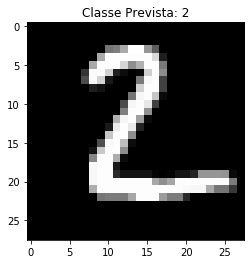

In [44]:
plt.imshow(x_imagem_teste.reshape((28, 28)), cmap = 'gray')
plt.title('Classe Prevista: ' + str(pred[0]))